In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import copy

In [293]:
import warnings
warnings.filterwarnings("ignore")

In [294]:
def table_results(pred, mod, table): 
    # store predictions and actual values in table
    pred_df = pd.DataFrame(pred)
    pred_df.index = table.index
    pred_df.columns = [mod]

    try: 
        result = table.join(pred_df)
    except ValueError: 
        result = table.drop(mod, axis= 1).join(pred_df)
    return result

In [295]:
def mape(actual, pred): 
    # compute mean prediction error
    actual, pred = np.array(actual), np.array(pred)
    actual[actual==0]=['nan']
    return np.nanmean(np.abs((actual - pred) / actual)) * 100

In [296]:
def getModelDict(train, s = 1, seed = 8888):
    # dictionary of orbit model specifications
    modelDict = {
                'ETSFull': ETSFull(
                            response_col=response_col,
                            date_col=date_col,
                            seasonality=365,
                            seed=seed
                            ),
                'DLTMAP': DLTMAP(
                        response_col=response_col,
                        date_col=date_col,
                        seasonality=s,
                        seed=seed
                        ),
               'DLTAggregation': DLTAggregated(
                            response_col=response_col,
                            date_col=date_col,
                            seasonality=s,
                            seed=seed
                            ),

                'DLTFull_Linear': DLTFull(
                            response_col=response_col,
                            date_col=date_col,
                            seasonality=365,
                            seed=seed,
                            global_trend_option = "linear"
                        ),
        
                'DLTFull_LogLinear': DLTFull(
                                    response_col=response_col,
                                    date_col=date_col,
                                    seasonality=365,
                                    seed=seed,
                                    global_trend_option = "loglinear"
                                ),
                'DLTFull_Flat': DLTFull(
                                response_col=response_col,
                                date_col=date_col,
                                seasonality=365,
                                seed=seed,
                                global_trend_option = "flat"
                                ),
                 # LGT requires positive data
                 'LGTFull': LGTFull(
                            response_col=response_col,
                            date_col=date_col,
                            seasonality=365,
                            seed=seed,
                        ),
                 'LGTMAP': LGTMAP(
                            response_col=response_col,
                            date_col=date_col,
                            seasonality=s,
                            seed=seed,
                        ),
                 'LGTAggregation': LGTAggregated(
                                    response_col=response_col,
                                    date_col=date_col,
                                    seasonality=s,
                                    seed=seed,
                                )}
    return modelDict

In [297]:
def runTheModel(df_train, df_test, model, modName, date_col, response_col, decompose=False):
    # fit orbit models
    model.fit(df_train)
    if not decompose:
        pred = model.predict(df_test[[date_col]]).prediction.unique()
    else:
        pred = model.predict(df_train, decompose=True)
        return pred
        
    error = mape(df_test[response_col], pred)
    prediction_df = pd.DataFrame.from_dict({'Date': df_test[date_col], 'Actual': df_test[response_col], 'Prediction': pred, 'MAPE': error, 'Model': modName})

    return prediction_df

# Import mileage and weather data

* Waze daily driven kilometers/miles percent change in Italy with respect to baseline
* NOAA average daily temperature for Italy

In [355]:
# import mileage data
url = "https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/waze_reports/waze_mobility.csv"

file = pd.read_csv(url,index_col="date")
df_waze = file[(file["country"] == "Italy") & (file["city"] == "Total")]

In [356]:
# import weather data
url = "https://storage.googleapis.com/covid19-open-data/v3/location/IT.csv"
file = pd.read_csv(url,index_col="date")
df_meteo = file["average_temperature_celsius"]

In [357]:
df_tot = df_waze.join(df_meteo)
data = df_tot[["driving_waze","average_temperature_celsius"]]
data.rename(columns={'driving_waze': 'waze', 'average_temperature_celsius': 'temp'}, inplace=True)
data.reset_index(level=0, inplace=True)

#data.dropna(axis=0, how = "any", inplace=True )
data.head()

,date,waze,temp
0,2020-03-01,-28.0,11.618056
1,2020-03-02,-17.0,11.839506
2,2020-03-03,-15.0,9.401235
3,2020-03-04,-20.0,8.783951
4,2020-03-05,-25.0,9.080247


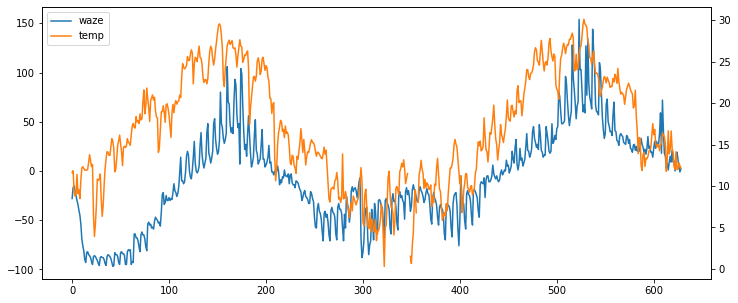

In [303]:
plt.figure(figsize=(12,5))

ax1 = data.waze.plot()
ax2 = data.temp.plot(secondary_y=True)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [304]:
# split the dataset
test_size = 62
train_df = data[:-test_size]
test_df = data[-test_size:]

# Forecast mileage data 


In [305]:
date_col = 'date'
response_col = 'waze'

# save results in dataframe
table_waze = test_df[[date_col, response_col]]
table_waze.rename(columns={'date': 'Date', 'waze': 'Actual'}, inplace=True)

## ARIMA

Arima model with no seasonality

In [307]:
import pmdarima
from pmdarima.arima import auto_arima

In [308]:
m = auto_arima(train_df[[response_col]])
pred_arima = m.predict(test_df.shape[0])
error_arima = mape(test_df[response_col], pred_arima)

In [309]:
# save results
table_waze = table_results(pred = pred_arima, mod = "Arima", table = table_waze)

errors_waze = {}
errors_waze["Arima"] = error_arima

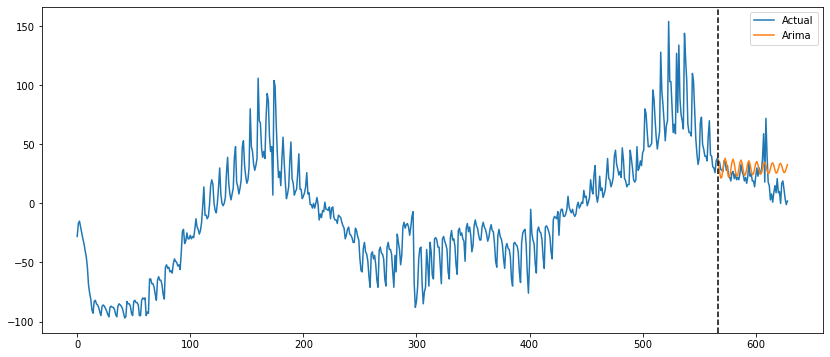

In [310]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(data[response_col], label = "Actual")
ax.plot(table_waze.Arima, label = "Arima")
plt.axvline(x=table_waze.index[0], color='k', linestyle='--')

plt.legend()
plt.show()

## Prophet

Generalized additive model (GAM) with three components: trend, seasonality and holidays.

$ y_t = g_t + s_t + h_t + \varepsilon_t$

where $g_t$ can be a linear or logistic growth curve, $s_t$ is the seasonality and $h_t$ is the holiday effect. Change points to fit the trend term can be supplied manually.

We fit an additive Prophet model with linear growth.

In [311]:
from prophet import Prophet

In [312]:
train_prophet = train_df[[date_col, response_col]]
train_prophet.rename(columns={date_col: 'ds', response_col: 'y'}, inplace=True)

In [313]:
m = Prophet(yearly_seasonality =True, 
            daily_seasonality = False, 
            weekly_seasonality = False)
m.fit(train_prophet)
future = m.make_future_dataframe(periods=test_size)
forecast = m.predict(future)

In [314]:
# save results
pred_prophet = forecast["yhat"][-test_size:]
error_prophet = mape(test_df[response_col], pred_prophet)

table_waze = table_results(pred = pred_prophet, mod = "Prophet", table = table_waze)
errors_waze["Prophet"] = error_prophet

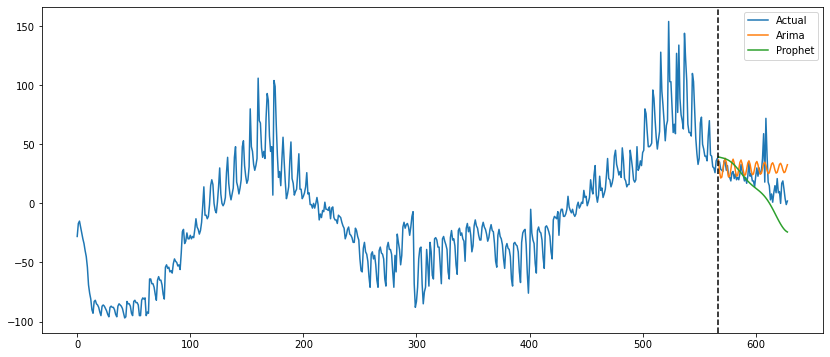

In [315]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(data[response_col], label = "Actual")
ax.plot(table_waze.Arima, label = "Arima")
ax.plot(table_waze.Prophet, label = "Prophet")

plt.axvline(x=table_waze.index[0], color='k', linestyle='--')

plt.legend()
plt.show()

## Exponential Smoothing (ETS)

We fit an ETS model with seasonality = 365.

$\hat{y}_{t|t-1} = Z^T \alpha_{t-1}$

$\varepsilon_t = y_t - \hat{y}_{t|t-1}$

$\alpha_t = T \alpha_{t-1} + k \varepsilon_t$

In [316]:
from orbit.models.dlt import ETSFull, ETSAggregated, ETSMAP, DLTMAP, DLTFull, DLTAggregated
from orbit.models.lgt import LGTMAP, LGTFull, LGTAggregated
from orbit.diagnostics.plot import plot_predicted_components

In [317]:
# initialize orbit models
models = getModelDict(train_df)

In [318]:
# select and run ETS model
select_model = 'ETSFull'
pred_ets = runTheModel(train_df, test_df, models[select_model], select_model, date_col, response_col)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [319]:
# save results
table_waze = table_results(pred = pred_ets.Prediction, mod = select_model, table = table_waze)
errors_waze[select_model] = pred_ets.MAPE.iloc[0]

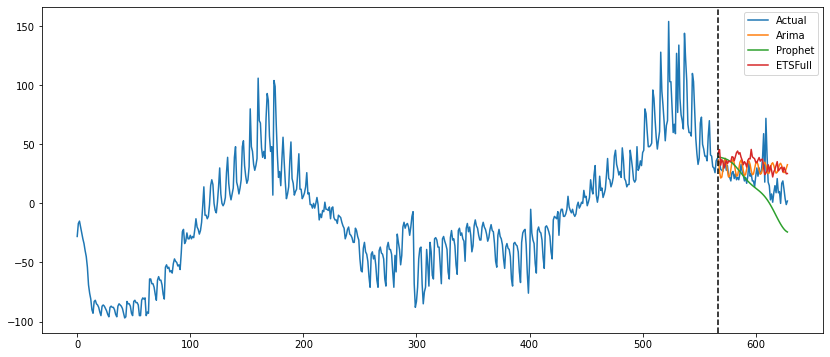

In [320]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(data[response_col], label = "Actual")
ax.plot(table_waze.Arima, label = "Arima")
ax.plot(table_waze.Prophet, label = "Prophet")
ax.plot(table_waze[select_model], label = select_model)

plt.axvline(x=table_waze.index[0], color='k', linestyle='--')

plt.legend()
plt.show()

## Damped local trend (DLT) model

Suited for $y_t \in \mathbb{R}$

$y_t = \mu_t + s_t + r_t + \varepsilon_t$

$\mu_t = D(t) + l_{t-1} + \theta b_{t-1}$

where
* $D(t)$ can be a linear, log-linear or logistic linear trend;
* $r_t = \Sigma_j \beta_j x_{jt}$, $\beta_j \sim N(\mu_j, \sigma_j)$, is a regression component which can be used to forecast with exogenous regressors (such as holidays); 

**Estimation methods**:
* Maximum a posteriori (MAP); 
* Full bayesian estimation (Full); 
* Aggregated Poisterior (Aggregated)

**Models fitted**: 
* DLTMAP with linear growth and no seasonality
* DLTAggregation with linear growth and no seasonality
* DLTFull with linear growth and seasonality = 365
* DLTFull with loglinear growth and seasonality = 365

In [321]:
# select DLT models
selection = ['DLTMAP', "DLTAggregation", "DLTFull_Linear", 'DLTFull_LogLinear']
models_sel = {}
for m in selection:
    if m in models: 
        models_sel[m] = models[m]

In [322]:
# Run the models
predictions = []
for mod in models_sel:
        try: 
            print('running', mod)
            predictions.append(runTheModel(train_df, test_df, models[mod], mod, date_col, response_col))
        except ValueError as e: 
            print("skipping", mod)
            print(e)
            pass

running DLTMAP
running DLTAggregation


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


running DLTFull_Linear


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


running DLTFull_LogLinear


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [323]:
# save results
for j in range(len(predictions)):
    fcst = predictions[j].Prediction
    name = predictions[j].Model.iloc[0]

    table_waze = table_results(pred = fcst, mod = name, table = table_waze)
    
    err = predictions[j].MAPE.iloc[0]
    errors_waze[name] = err

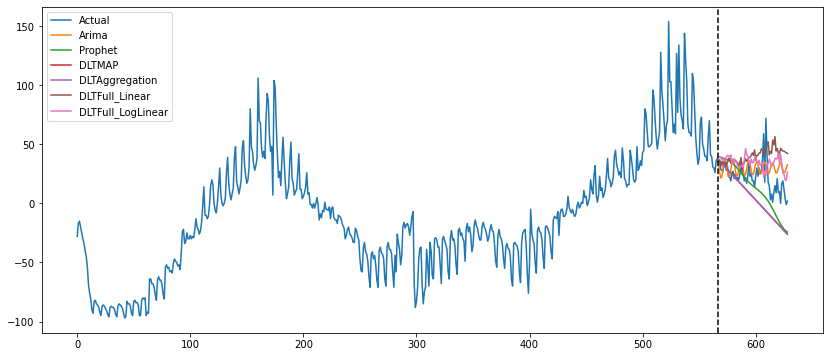

In [324]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(data[response_col], label = "Actual")
ax.plot(table_waze.Arima, label = "Arima")
ax.plot(table_waze.Prophet, label = "Prophet")

for model in selection:  
    ax.plot(table_waze[model], label=model)

plt.axvline(x=table_waze.index[0], color='k', linestyle='--')

plt.legend()
plt.show()

## Compare models prediction error

<BarContainer object of 7 artists>

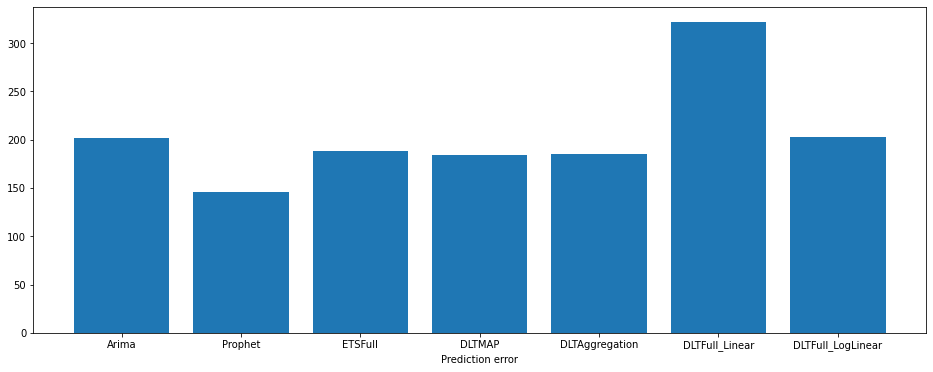

In [325]:
# plot prediction error
fig, ax = plt.subplots(figsize=(16,6))
plt.xlabel('Prediction error')
keys = errors_waze.keys()
values = errors_waze.values()

plt.bar(keys, values)

### Decomoposition of best Orbit model

In [326]:
errors_copy =  copy.deepcopy(errors_waze)
keys_to_remove = ["Arima", "Prophet"]
for key in keys_to_remove:
    del errors_copy[key]

best = min(errors_copy, key=errors_copy.get)

best_dec = runTheModel(train_df, test_df, models[best], best, date_col, response_col, decompose = True)

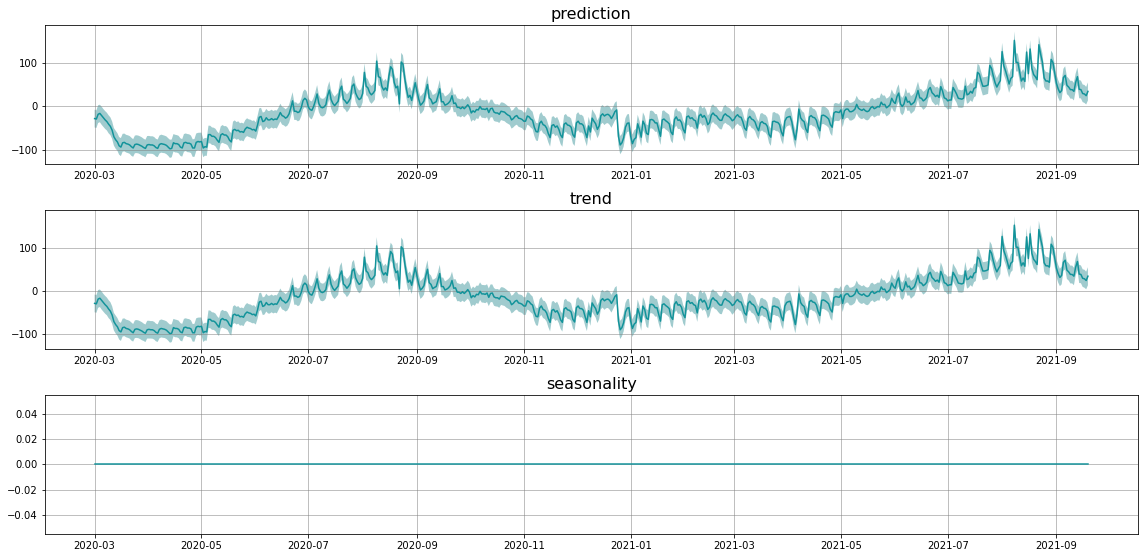

In [327]:
_ = plot_predicted_components(best_dec, date_col, plot_components=['prediction', 'trend', 'seasonality'])

### Decomposition of DLTFull loglinear trend model

In [328]:
best = "DLTFull_LogLinear"
best_dec = runTheModel(train_df, test_df, models[best], best, date_col, response_col, decompose = True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


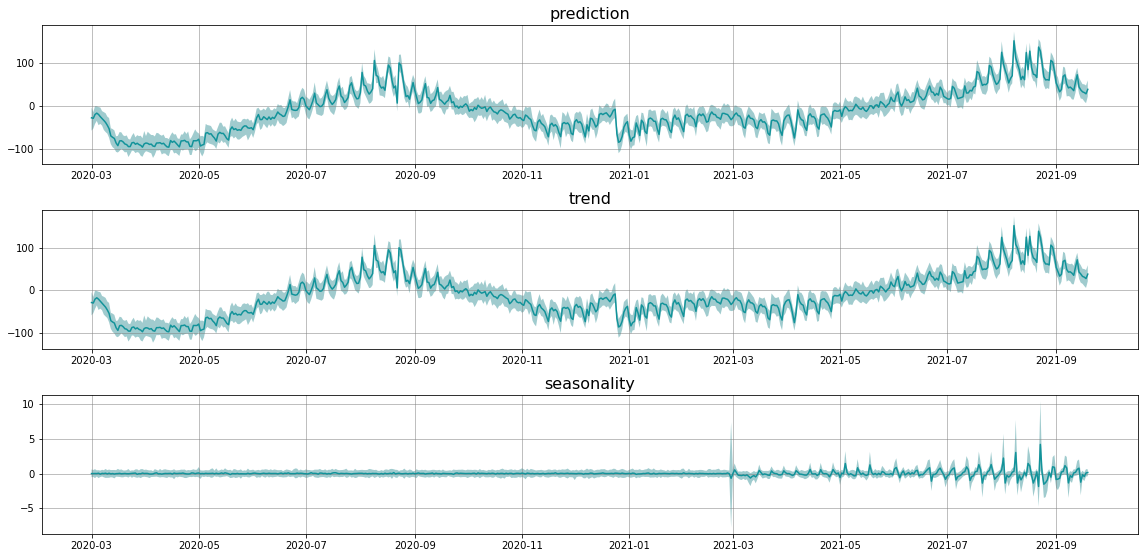

In [329]:
_ = plot_predicted_components(best_dec, date_col, plot_components=['prediction', 'trend', 'seasonality'])

# Forecast temperature 

In [330]:
date_col = 'date'
response_col = 'temp'

In [358]:
# remove NAs from training set
train_clean = train_df.copy()
train_clean.dropna(axis=0, how = "any", inplace=True )

# save results in dataframe
table_temp = test_df[[date_col, response_col]]
table_temp.rename(columns={'date': 'Date', 'temp': 'Actual'}, inplace=True)

## ARIMA

In [332]:
m = auto_arima(train_clean[[response_col]])
pred_arima = m.predict(test_df.shape[0])
error_arima = mape(test_df[response_col], pred_arima)

In [333]:
# save results
table_temp = table_results(pred = pred_arima, mod = "Arima", table = table_temp)

errors_temp = {}
errors_temp["Arima"] = error_arima

## Prophet

Fit a multiplicative model with flat growth and yearly seasonality

In [334]:
train_prophet = train_clean[[date_col, response_col]]
train_prophet.rename(columns={date_col: 'ds', response_col: 'y'}, inplace=True)

In [335]:
m = Prophet(yearly_seasonality =True, 
            daily_seasonality = False, 
            weekly_seasonality = False, 
           growth = "flat", 
           seasonality_mode = "multiplicative")
m.fit(train_prophet)
future = m.make_future_dataframe(periods=test_size)
fcst_temp = m.predict(future)

In [336]:
# save results
pred_prophet = fcst_temp["yhat"][-test_size:]
error_prophet = mape(test_df[response_col], pred_prophet)

table_temp = table_results(pred = pred_prophet, mod = "Prophet", table = table_temp)
errors_temp["Prophet"] = error_prophet

# Local and Global Trend (LGT) model 

LGT is an additive model taking log-transformation response so as to convert the model to multiplicative.

$y_t = \mu_t + s_t + \varepsilon_t$

$\mu_t = l_{t-1} + \xi_1 b_{t-1} + \xi_2 l_{t-1}^{\lambda}$

$\varepsilon_t \sim Student(\nu, 0, \sigma)$

$\sigma \sim HalfCauchy(0, \gamma_0)$

where: 
* $l_{t−1}$ is the level;
* $\xi_1 b_{t−1}$ is the local trend;
* $\xi_2 l_{t-1}^{\lambda}$ is the global trend;
* $s_t$ is the seasonality; 
* $\varepsilon_t$ is the error term; 

Since it is assumed that $l_t > 0, \forall t$, negative response values are not allowed ($y_t >0)$.

**Models fitted**: 
* LGTMAP with no seasonality; 
* LGTAggregation with no seasonality; 
* LGTFull with seasonality = 365; 
* ETS full with seasonality = 365; 
* DLTMAP with no seasonality; 
* DLTFull with flat growth and seasonality = 365; 
* DLTFull with linear growth and seasonality = 365; 

In [337]:
# initialize orbit models
models = getModelDict(train_df)

In [338]:
# select models
selection = ['LGTMAP','LGTFull',"LGTAggregation",'ETSFull', 'DLTMAP', "DLTFull_Flat", "DLTFull_Linear"]
models_sel = {}
for m in selection:
    if m in models: 
        models_sel[m] = models[m]

In [339]:
# Run the models
predictions = []
for mod in models_sel:
        try: 
            print('running', mod)
            predictions.append(runTheModel(train_clean, test_df, models[mod], mod, date_col, response_col))
        except ValueError as e: 
            print("skipping", mod)
            print(e)
            pass

running LGTMAP
running LGTFull


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


running LGTAggregation


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


running ETSFull


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


running DLTMAP
running DLTFull_Flat


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


running DLTFull_Linear


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [340]:
# save results
for j in range(len(predictions)):
    fcst = predictions[j].Prediction
    name = predictions[j].Model.iloc[0]

    table_temp = table_results(pred = fcst, mod = name, table = table_temp)
    
    err = predictions[j].MAPE.iloc[0]
    errors_temp[name] = err

## Compare models

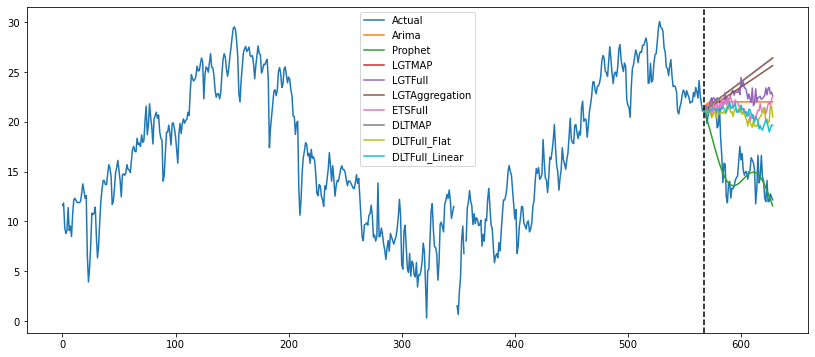

In [341]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(data[response_col], label = "Actual")
ax.plot(table_temp.Arima, label = "Arima")
ax.plot(table_temp.Prophet, label = "Prophet")

for model in selection:  
    ax.plot(table_temp[model], label=model)

plt.axvline(x=table_temp.index[0], color='k', linestyle='--')

plt.legend()
plt.show()

<BarContainer object of 9 artists>

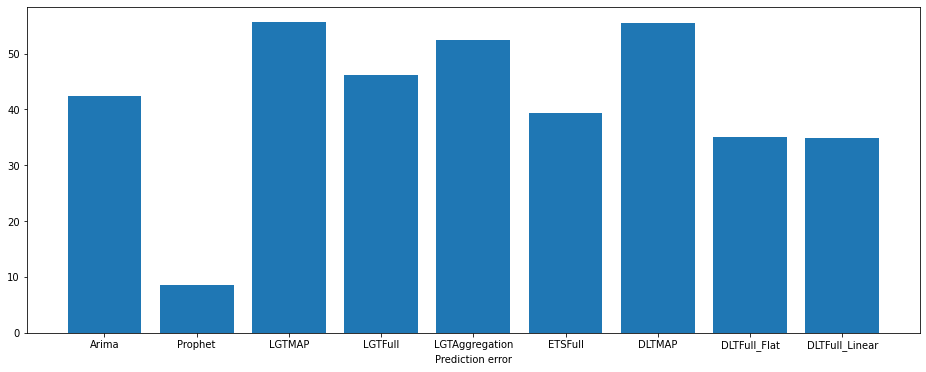

In [342]:
# plot prediction error
fig, ax = plt.subplots(figsize=(16,6))
plt.xlabel('Prediction error')
keys = errors_temp.keys()
values = errors_temp.values()

plt.bar(keys, values)

### Decomposition of LGTFull

In [343]:
best = "LGTFull"
best_dec = runTheModel(train_clean, test_df, models[best], best, date_col, response_col, decompose = True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


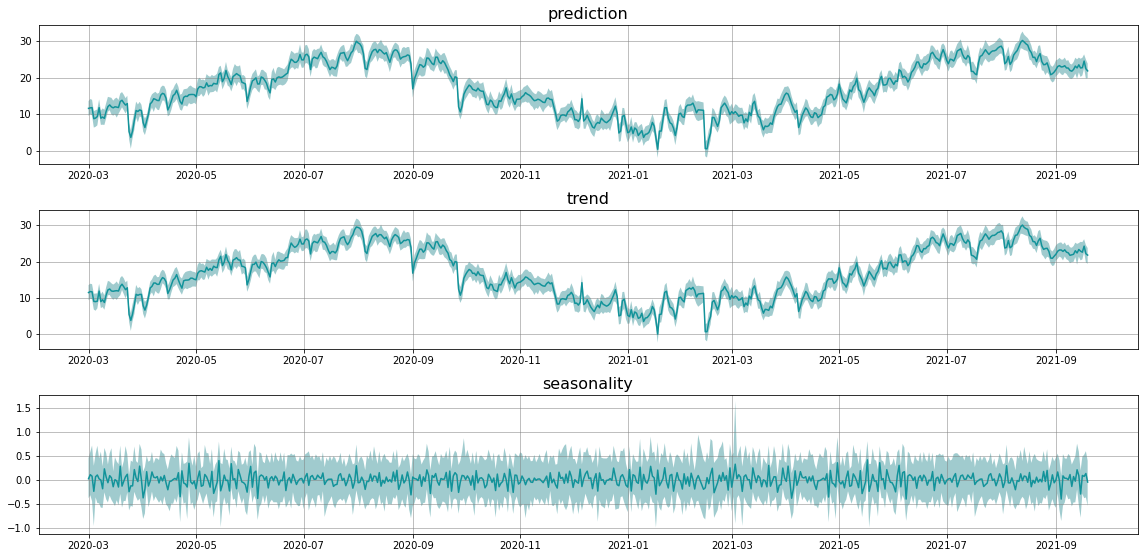

In [344]:
_ = plot_predicted_components(best_dec, date_col, plot_components=['prediction', 'trend', 'seasonality'])

# Regression models

Predict daily mileage using weather data 

In [345]:
response_col = "waze"
models_keep = "DLTFull_LogLinear", "Prophet"

# store results
table_reg = table_waze[["Date", "Actual", models_keep[0], models_keep[1]]]

errors_reg = {}
for k in models_keep: 
    errors_reg[k] = errors_waze[k]

## DLT regression model

DLTFull model with loglinear growth and seasonality = 365

In [346]:
dlt_reg = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=['temp'],
    regressor_sign=["+"],
    seasonality=365,
    #num_warmup=4000,
    global_trend_option = "loglinear",
    seed=8888
)

In [347]:
dlt_reg.fit(df=train_clean)
pred_dlt = dlt_reg.predict(test_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [348]:
#save results
model_select = "DLT_Reg"
error_dlt_reg = mape(test_df[response_col], pred_dlt["prediction"])
errors_reg[model_select] = error_dlt_reg

table_reg = table_results(pred = pred_dlt["prediction"], mod = model_select, table = table_reg)

# Prophet regression

Prophet model with linear growth and additive yearly seasonality

In [349]:
train_prophet = train_clean[[date_col, response_col, "temp"]]
train_prophet.rename(columns={date_col: 'ds', response_col: 'y'}, inplace=True)

In [350]:
m = Prophet(yearly_seasonality =True, 
            daily_seasonality = False, 
            weekly_seasonality = False)
m.add_regressor("temp")
m.fit(train_prophet)
future = m.make_future_dataframe(periods=test_size)
future["temp"] = fcst_temp["yhat"]
forecast = m.predict(future)

In [351]:
# save results
pred_prophet = forecast["yhat"][-test_size:]
error_prophet = mape(test_df[response_col], pred_prophet)

table_reg = table_results(pred = pred_prophet, mod = "Prophet_reg", table = table_reg)
errors_reg["Prophet_reg"] = error_prophet

## Compare results

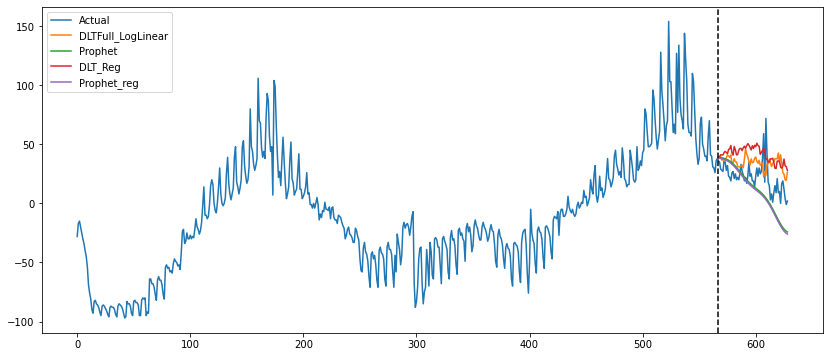

In [352]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(data[response_col], label = "Actual")

for model in list( table_reg.columns[2:] ):  
    ax.plot(table_reg[model], label=model)

plt.axvline(x=table_reg.index[0], color='k', linestyle='--')

plt.legend()
plt.show()

<BarContainer object of 4 artists>

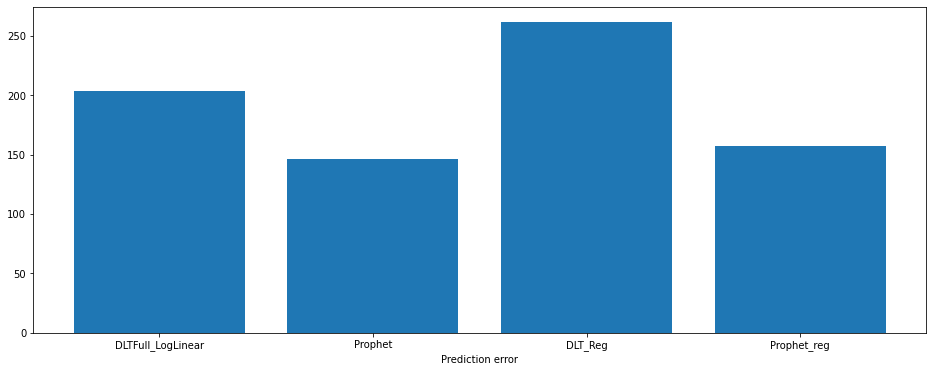

In [353]:
# plot prediction error
fig, ax = plt.subplots(figsize=(16,6))
plt.xlabel('Prediction error')
keys = errors_reg.keys()
values = errors_reg.values()

plt.bar(keys, values)